## Install Library

In [1]:
!pip install -q wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 3.4 MB/s eta 0:00:00a 0:00:01


## Importing Library

In [2]:
import numpy as np
import pandas as pd
import os
import shutil
import csv
import itertools
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from scipy import stats
import wfdb

import wfdb
import numpy as np
from scipy.signal import savgol_filter
import os

In [3]:
record_file = []
record_path = '/kaggle/input/apena-ecg/apnea-ecg-database-1.0.0/RECORDS'

with open(record_path, 'r') as f:
    record_file.extend(line.strip() for line in f)

print(record_file)

['a01', 'a01er', 'a01r', 'a02', 'a02er', 'a02r', 'a03', 'a03er', 'a03r', 'a04', 'a04er', 'a04r', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'b01', 'b01er', 'b01r', 'b02', 'b03', 'b04', 'b05', 'c01', 'c01er', 'c01r', 'c02', 'c02er', 'c02r', 'c03', 'c03er', 'c03r', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35']


In [4]:
print(f"The length of the total file in the Apnea ECG: {len(record_file)}")
print(record_file[:43])

The length of the total file in the Apnea ECG: 86
['a01', 'a01er', 'a01r', 'a02', 'a02er', 'a02r', 'a03', 'a03er', 'a03r', 'a04', 'a04er', 'a04r', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'b01', 'b01er', 'b01r', 'b02', 'b03', 'b04', 'b05', 'c01', 'c01er', 'c01r', 'c02', 'c02er', 'c02r', 'c03', 'c03er']


## **Training Set (35 ECG Records):**
    * a01–a20: 20 apnea-heavy records.
    * b01–b05: 5 borderline/control records.
    * c01–c10: 10 control records.
## **Test Set (35 ECG Records):**
    * x01–x35: 35 withheld test records (no r or er files, as annotations are not released).

In [5]:
def extract_segments_from_multiple_files(record_list, base_path="/kaggle/input/apena-ecg/apnea-ecg-database-1.0.0"):
    segment_labels = []
    segments = []
    
    for name in record_list:
        record_name = f"{base_path}/{name}"
        try:
            # Load ECG record (single channel)
            record = wfdb.rdrecord(record_name, channels=[0])
            signal = record.p_signal.flatten()  # Flatten to 1D array
            fs = record.fs  # 100 Hz for Apnea-ECG
            
            # Load annotations from .apn file
            annotation = wfdb.rdann(record_name, 'apn')
            apnea_labels = annotation.symbol  # 'A' for apnea, 'N' for normal
            
            # Segment into 1-minute intervals (6,000 samples)
            segment_length = fs * 60  # 100 Hz * 60 seconds = 6,000 samples
            num_segments = len(signal) // segment_length
            
            for i in range(num_segments):
                start = i * segment_length
                end = (i + 1) * segment_length
                segment = signal[start:end]
                
                # Check for signal loss (>0.5s = 50 samples at 100 Hz)
                if np.any(np.isnan(segment)) or np.count_nonzero(segment == 0) > 50:
                    continue  # Exclude segments with >0.5s loss
                
                # Preprocessing
                # 1. Savitzky-Golay filter (3rd order, window=5)
                segment = savgol_filter(segment, window_length=5, polyorder=3)
                # 2. Normalization (mean=0, std=1)
                segment = (segment - np.mean(segment)) / np.std(segment)
                
                # Append segment and label
                if len(segment) == segment_length:  # Ensure full 6,000 samples
                    segments.append(segment)
                    label = 1 if apnea_labels[i] == 'A' else 0
                    segment_labels.append(label)
                    
        except Exception as e:
            print(f"Error processing record {name}: {e}")
            continue
    
    return segment_labels, segments

# Training record list (35 records from Apnea-ECG training set)
record_list = [
    'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 
    'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'b01', 'b02', 'b03', 'b04', 
    'b05', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10'
]

# Extract segments and labels
labels, extracted_segments = extract_segments_from_multiple_files(record_list)

# Basic validation
print(f"Total segments extracted: {len(extracted_segments)}")
print(f"Total labels: {len(labels)}")
print(f"Length of first segment: {len(extracted_segments[0]) if extracted_segments else 'N/A'}")
print(f"Apnea segments: {sum(1 for l in labels if l == 1)}")
print(f"Normal segments: {sum(1 for l in labels if l == 0)}")

Error processing record b02: list index out of range
Total segments extracted: 6126
Total labels: 6125
Length of first segment: 6000
Apnea segments: 2582
Normal segments: 3543


In [6]:
print(f"The sample points of the segmented beats: {extracted_segments[6]}")
print(f"The sample labels: {labels[:10]}")

The sample points of the segmented beats: [-0.07363032 -0.06098994  0.03170613 ... -0.48638066 -0.52177371
 -0.58076212]
The sample labels: [1, 1, 1, 1, 1, 1, 0, 1, 0, 0]


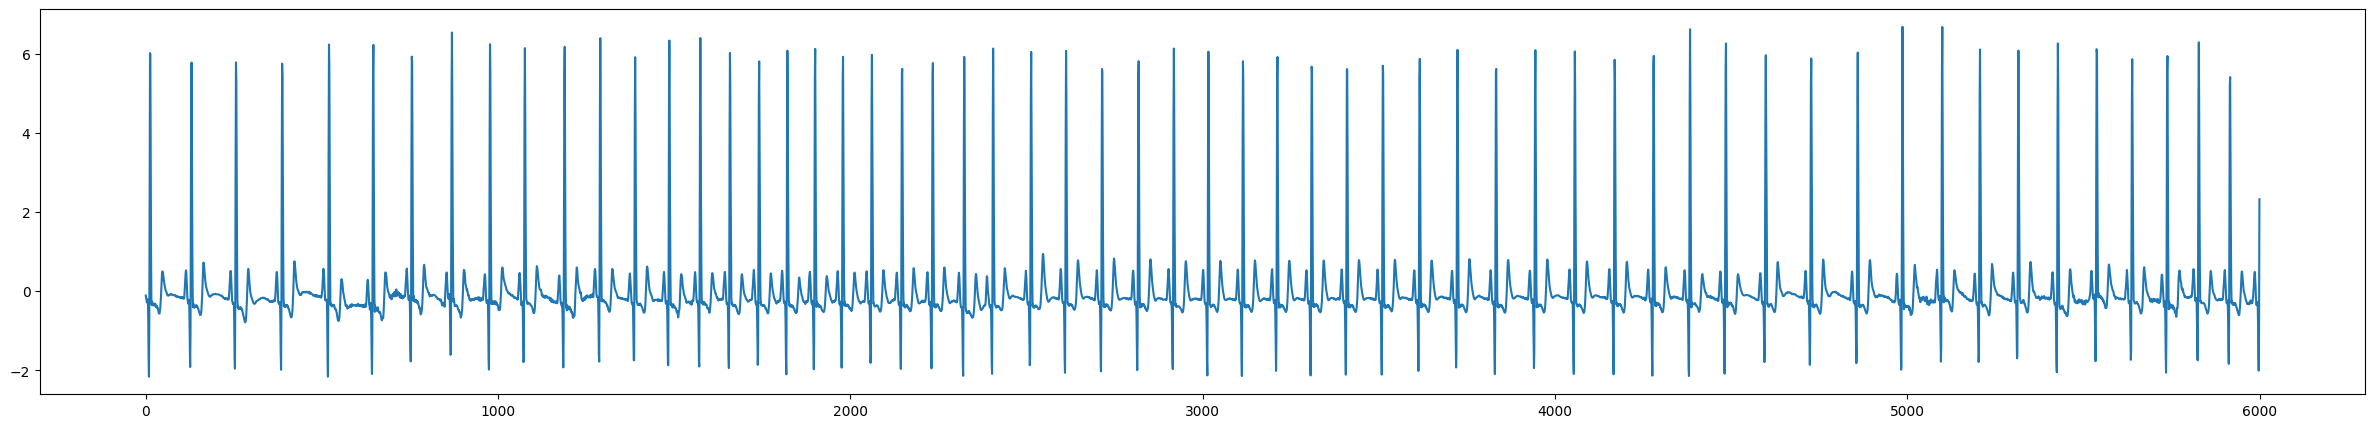

In [7]:
plt.figure(figsize = (30, 5))
plt.plot(extracted_segments[7])

In [8]:
recording_file = '/kaggle/input/apena-ecg/apnea-ecg-database-1.0.0/b02'

try:
    record = wfdb.rdrecord(recording_file, channels=[0])
    signal = record.p_signal.flatten()  # Flatten to 1D array
    fs = record.fs  # 100 Hz for Apnea-ECG
            
    # Load annotations from .apn file
    annotation = wfdb.rdann(recording_file, 'apn')
    apnea_labels = annotation.symbol
    
    # Calculate duration
    signal_length = len(signal)
    duration_seconds = signal_length / fs
    duration_minutes = duration_seconds / 60  # Convert to minutes for readability
    
    print(f"Metadata:")
    print(f"   The length of the signal: {signal_length} samples")
    print(f"   Sampling frequency: {fs} Hz")
    print(f"   Duration: {duration_seconds} seconds ({duration_minutes:.2f} minutes)")
    print(f"   The annotation: {apnea_labels}")
except Exception as e:
    print(f"The error: {e}")

Metadata:
   The length of the signal: 3170500 samples
   Sampling frequency: 100 Hz
   Duration: 31705.0 seconds (528.42 minutes)
   The annotation: ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [9]:
import wfdb
import numpy as np
from scipy.signal import savgol_filter
import os

def extract_segments_from_multiple_files(record_list, base_path="/kaggle/input/apena-ecg/apnea-ecg-database-1.0.0"):
    segment_labels = []
    segments = []
    
    for name in record_list:
        record_name = f"{base_path}/{name}"
        try:
            # Load ECG record (single channel)
            record = wfdb.rdrecord(record_name, channels=[0])
            signal = record.p_signal.flatten()  # Flatten to 1D array
            fs = record.fs  # 100 Hz for Apnea-ECG
            
            # Load annotations from .apn file
            annotation = wfdb.rdann(record_name, 'apn')
            apnea_labels = annotation.symbol  # 'A' for apnea, 'N' for normal
            
            # Segment into 1-minute intervals (6,000 samples)
            segment_length = fs * 60  # 100 Hz * 60 seconds = 6,000 samples
            num_segments = (len(signal) + segment_length - 1) // segment_length  # Ceiling division
            
            # Pad signal with zeros if needed to make it divisible by segment_length
            if len(signal) % segment_length != 0:
                padding_length = segment_length - (len(signal) % segment_length)
                signal = np.pad(signal, (0, padding_length), mode='constant', constant_values=0)
            
            for i in range(num_segments):
                start = i * segment_length
                end = (i + 1) * segment_length
                segment = signal[start:end]
                
                # Check for signal loss (>0.5s = 50 samples at 100 Hz)
                if np.any(np.isnan(segment)) or np.count_nonzero(segment == 0) > 50:
                    continue  # Exclude segments with >0.5s loss
                
                # Preprocessing
                # 1. Savitzky-Golay filter (3rd order, window=5)
                segment = savgol_filter(segment, window_length=5, polyorder=3)
                # 2. Normalization (mean=0, std=1)
                # Avoid division by zero if segment is all zeros (e.g., padded)
                std = np.std(segment)
                segment = (segment - np.mean(segment)) / (std if std != 0 else 1)
                
                # Append segment and label
                if len(segment) == segment_length:  # Ensure full 6,000 samples
                    segments.append(segment)
                    # Handle index out of bounds for apnea_labels
                    if i < len(apnea_labels):
                        label = 1 if apnea_labels[i] == 'A' else 0
                    else:
                        label = 0  # Default to normal if no annotation
                    segment_labels.append(label)
                    
        except Exception as e:
            print(f"Error processing record {name}: {e}")
            continue
    
    return segment_labels, segments

# Training record list (35 records from Apnea-ECG training set)
record_list = [
    'a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 
    'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'b01', 'b02', 
    'b03', 'b04', 'b05', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10'
]

# Extract segments and labels
labels, extracted_segments = extract_segments_from_multiple_files(record_list)

# Basic validation
print(f"Total segments extracted: {len(extracted_segments)}")
print(f"Total labels: {len(labels)}")
print(f"Length of first segment: {len(extracted_segments[0]) if extracted_segments else 'N/A'}")
print(f"Apnea segments: {sum(1 for l in labels if l == 1)}")
print(f"Normal segments: {sum(1 for l in labels if l == 0)}")

Total segments extracted: 6136
Total labels: 6136
Length of first segment: 6000
Apnea segments: 2582
Normal segments: 3554


In [10]:
print("Converting beats to array...")
signals = np.array(extracted_segments)  

print("Creating DataFrame with 257 columns...")
signal_columns = [f"signal_{i}" for i in range(6000)] 
df = pd.DataFrame(signals, columns=signal_columns)
df["qrs_label"] = labels

# Save to CSV
csv_path = "mitbih_beats_expanded.csv"
df.to_csv(csv_path, index=False)
print(f"CSV saved as '{csv_path}'")

# Validate the CSV
print("Validating CSV...")
df_loaded = pd.read_csv(csv_path)
print(f"CSV Shape: {df_loaded.shape}")
print(f"Sample data:\n{df_loaded.head()}")

# Validate signals and labels shapes
signals_loaded = df_loaded[[f"signal_{i}" for i in range(6000)]].values
labels_loaded = df_loaded["qrs_label"].values
print(f"Signals Shape: {signals_loaded.shape}")
print(f"Labels Shape: {labels_loaded.shape}")

Converting beats to array...
Creating DataFrame with 257 columns...
CSV saved as 'mitbih_beats_expanded.csv'
Validating CSV...
CSV Shape: (6136, 6001)
Sample data:
   signal_0  signal_1  signal_2  signal_3  signal_4  signal_5  signal_6  \
0 -0.260746 -0.291291 -0.294994 -0.296475 -0.293883 -0.290921 -0.270187   
1 -0.277807 -0.176182 -0.036448  0.131959  0.307625  0.439738  0.477847   
2  0.190197  0.100872  0.036697 -0.023315 -0.088878 -0.162766 -0.219310   
3 -0.121496  0.031846  0.164563  0.238812  0.244193  0.209758  0.147704   
4 -0.263606 -0.282481 -0.282481 -0.287873 -0.319511 -0.803068 -1.620979   

   signal_7  signal_8  signal_9  ...  signal_5991  signal_5992  signal_5993  \
0 -0.256488 -0.239826 -0.229459  ...     0.253346     0.177815     0.103395   
1  0.445545  0.372956  0.286574  ...    -0.176545    -0.189611    -0.175456   
2 -0.268222 -0.297014 -0.321990  ...    -0.110039    -0.131546    -0.111079   
3  0.073813  0.002433 -0.040252  ...    -0.358054    -0.365228    -0.

In [11]:
import pandas as pd

# Load dataset
csv_file = "/kaggle/working/mitbih_beats_expanded.csv"
df = pd.read_csv(csv_file)

# Separate the last column
label_column = df.iloc[:, -1]  # Extract last column (qrs_label)
df = df.iloc[:, :-1].astype(float)  # Convert all other columns to float

# Reattach the label column
df["qrs_label"] = label_column  # Add label back as the last column

# Save back to CSV
df.to_csv("/kaggle/working/mitbih_beats_expanded.csv", index=False)

# Display info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6136 entries, 0 to 6135
Columns: 6001 entries, signal_0 to qrs_label
dtypes: float64(6000), int64(1)
memory usage: 280.9 MB
None


In [12]:
data = pd.read_csv('/kaggle/working/mitbih_beats_expanded.csv')

data.head(10)

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_5991,signal_5992,signal_5993,signal_5994,signal_5995,signal_5996,signal_5997,signal_5998,signal_5999,qrs_label
0,-0.260746,-0.291291,-0.294994,-0.296475,-0.293883,-0.290921,-0.270187,-0.256488,-0.239826,-0.229459,...,0.253346,0.177815,0.103395,0.052671,0.020089,-0.017677,-0.062847,-0.109128,-0.157261,1
1,-0.277807,-0.176182,-0.036448,0.131959,0.307625,0.439738,0.477847,0.445545,0.372956,0.286574,...,-0.176545,-0.189611,-0.175456,-0.189611,-0.177634,-0.199411,-0.119562,0.014728,0.163536,1
2,0.190197,0.100872,0.036697,-0.023315,-0.088878,-0.162766,-0.219310,-0.268222,-0.297014,-0.321990,...,-0.110039,-0.131546,-0.111079,-0.132587,-0.084715,-0.000421,0.133480,0.267034,0.491647,1
3,-0.121496,0.031846,0.164563,0.238812,0.244193,0.209758,0.147704,0.073813,0.002433,-0.040252,...,-0.358054,-0.365228,-0.366304,-0.388185,-0.395717,-0.421543,-0.439836,-0.464945,-0.471222,1
4,-0.263606,-0.282481,-0.282481,-0.287873,-0.319511,-0.803068,-1.620979,-1.888104,-0.104158,3.672257,...,0.096096,0.302102,0.480424,0.542981,0.529319,0.466403,0.390544,0.288080,0.207188,1
5,0.306621,0.192409,0.124249,0.073775,0.023300,-0.028280,-0.082070,-0.125913,-0.164967,-0.185967,...,-0.410708,-0.422866,-0.463025,-0.478130,-0.515342,-0.530816,-0.583501,-0.629554,-0.612975,1
6,-0.073630,-0.060990,0.031706,0.140582,0.258222,0.411929,0.395749,0.306424,0.119346,0.026987,...,-0.329977,-0.339078,-0.351550,-0.368404,-0.399078,-0.443909,-0.486381,-0.521774,-0.580762,0
7,-0.109299,-0.176795,-0.214821,-0.285550,-0.269579,-0.283268,-0.206075,-0.722088,-1.668554,-2.162131,...,-0.354757,-0.285550,-0.293155,-0.276043,-0.760114,-1.552195,-2.005464,-0.935033,2.322841,1
8,-0.153759,-0.186553,-0.179826,-0.152245,-0.215478,-0.737823,-1.662101,-2.079169,-0.182516,3.791071,...,-0.296201,-0.278039,-0.313691,-0.303601,-0.335217,-0.331181,-0.381297,-0.413250,-0.432589,0
9,4.698835,6.037241,4.674500,2.400601,0.895676,-0.115603,-0.257787,-0.251877,-0.303675,-0.290812,...,0.032839,0.267146,0.410026,0.462519,0.472253,0.386386,0.270275,0.188580,0.113838,0


In [13]:
data.isnull().values.any()

False

In [14]:
X = data.iloc[:, :-1]
X.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_5990,signal_5991,signal_5992,signal_5993,signal_5994,signal_5995,signal_5996,signal_5997,signal_5998,signal_5999
0,-0.260746,-0.291291,-0.294994,-0.296475,-0.293883,-0.290921,-0.270187,-0.256488,-0.239826,-0.229459,...,0.328136,0.253346,0.177815,0.103395,0.052671,0.020089,-0.017677,-0.062847,-0.109128,-0.157261
1,-0.277807,-0.176182,-0.036448,0.131959,0.307625,0.439738,0.477847,0.445545,0.372956,0.286574,...,-0.184167,-0.176545,-0.189611,-0.175456,-0.189611,-0.177634,-0.199411,-0.119562,0.014728,0.163536
2,0.190197,0.100872,0.036697,-0.023315,-0.088878,-0.162766,-0.219310,-0.268222,-0.297014,-0.321990,...,-0.127383,-0.110039,-0.131546,-0.111079,-0.132587,-0.084715,-0.000421,0.133480,0.267034,0.491647
3,-0.121496,0.031846,0.164563,0.238812,0.244193,0.209758,0.147704,0.073813,0.002433,-0.040252,...,-0.370250,-0.358054,-0.365228,-0.366304,-0.388185,-0.395717,-0.421543,-0.439836,-0.464945,-0.471222
4,-0.263606,-0.282481,-0.282481,-0.287873,-0.319511,-0.803068,-1.620979,-1.888104,-0.104158,3.672257,...,-0.116741,0.096096,0.302102,0.480424,0.542981,0.529319,0.466403,0.390544,0.288080,0.207188


In [15]:
y = data.iloc[:, -1]
y

0       1
1       1
2       1
3       1
4       1
       ..
6131    1
6132    1
6133    1
6134    1
6135    0
Name: qrs_label, Length: 6136, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# First, split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [17]:
print(f"The shape of X_train: {X_train.shape}")
print(f"The shape of X_test: {X_test.shape}")
print(f"The shape of X_valid: {X_valid.shape}")
print(f"The length of y_train: {len(y_train)}")
print(f"The length of y_test: {len(y_test)}")
print(f"The shape of y_valid: {len(y_valid)}")

The shape of X_train: (3681, 6000)
The shape of X_test: (1228, 6000)
The shape of X_valid: (1227, 6000)
The length of y_train: 3681
The length of y_test: 1228
The shape of y_valid: 1227


In [18]:
X_train = X_train.values
train_x = X_train.reshape(len(X_train), X_train.shape[1],1)
print(np.shape(train_x))
# print(train_x[0])
print(type(train_x))
# X_train = np.array(X_train)

X_test = X_test.values
test_x = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(test_x))
# print(train_x[0])
print(type(test_x))

X_valid = X_valid.values
valid_x = X_valid.reshape(len(X_valid), X_valid.shape[1],1)
print(np.shape(valid_x))
# print(train_x[0])
print(type(valid_x))

(3681, 6000, 1)
<class 'numpy.ndarray'>
(1228, 6000, 1)
<class 'numpy.ndarray'>
(1227, 6000, 1)
<class 'numpy.ndarray'>


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = 2
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print("Train y shape:", y_train.shape)
print("Valid y shape:", y_valid.shape)
print("Test y shape:", y_test.shape)

Train y shape: (3681, 2)
Valid y shape: (1227, 2)
Test y shape: (1228, 2)


Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4761 - loss: 0.8476 - val_accuracy: 0.5827 - val_loss: 0.6752
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5756 - loss: 0.6748 - val_accuracy: 0.5232 - val_loss: 0.6824
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5392 - loss: 0.6735 - val_accuracy: 0.5852 - val_loss: 0.6593
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5794 - loss: 0.6556 - val_accuracy: 0.5852 - val_loss: 0.6583
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5483 - loss: 0.6631 - val_accuracy: 0.5852 - val_loss: 0.6587
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5732 - loss: 0.6611 - val_accuracy: 0.5371 - val_loss: 0.6565
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5551 - loss: 0.6482 - val_accuracy: 0.6544 - val_loss: 0.6405
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6187 - loss: 0.6410 - val_accuracy: 0.6642 - val_loss: 0.6295
Epoch 9

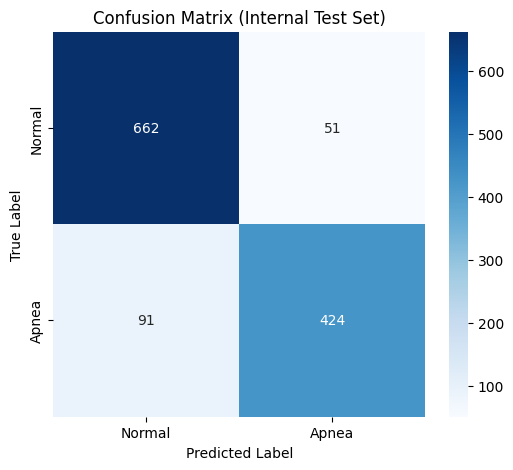

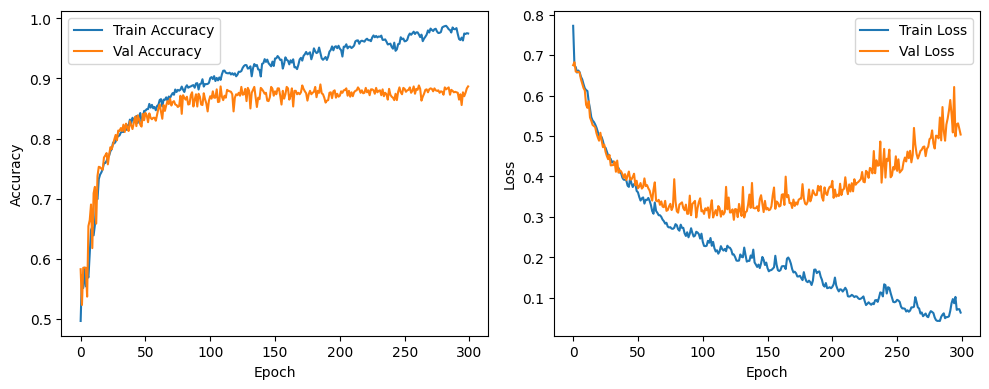

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, auc)
import seaborn as sns
from scipy import stats

# Assuming X_train, y_train, X_valid, y_valid, X_test, y_test are already defined as in your code
# y_train, y_valid, y_test are one-hot encoded (shape: [samples, 2])

def train_model(X_train, y_train, X_valid, y_valid, X_test, y_test):
    # Build model (unchanged from your code)
    def conv_fan_block(x, filters, kernel_size):
        f_gelu = filters // 3
        f_sine = filters // 3
        f_cosine = filters - (f_gelu + f_sine)
        x_gelu = layers.Conv1D(f_gelu, kernel_size, padding='same', activation='gelu')(x)
        x_sine = layers.Conv1D(f_sine, kernel_size, padding='same', activation=tf.math.sin)(x)
        x_cosine = layers.Conv1D(f_cosine, kernel_size, padding='same', activation=tf.math.cos)(x)
        return layers.Concatenate()([x_gelu, x_sine, x_cosine])

    def attention_block(x, filters):
        attn = layers.Conv1D(filters, kernel_size=1, padding='same')(x)
        attn = layers.Activation('sigmoid')(attn)
        return layers.Multiply()([x, attn])

    def fc_fan_block(x, units):
        u_gelu = (units * 4) // 6
        u_sine = units // 6
        u_cosine = units - (u_gelu + u_sine)
        x_gelu = layers.Dense(u_gelu, activation='gelu')(x)
        x_sine = layers.Dense(u_sine, activation=tf.math.sin)(x)
        x_cosine = layers.Dense(u_cosine, activation=tf.math.cos)(x)
        return layers.Concatenate()([x_gelu, x_sine, x_cosine])

    def create_cfan_model(input_shape=(6000, 1)):
        inputs = layers.Input(shape=input_shape)
        x = conv_fan_block(inputs, filters=12, kernel_size=64)
        skip = x
        x = conv_fan_block(x, filters=12, kernel_size=64)
        x = attention_block(x, filters=12)
        x = layers.Add()([x, skip])
        x = layers.Activation('relu')(x)
        x = layers.AveragePooling1D(pool_size=4, strides=4)(x)
        x = conv_fan_block(x, filters=12, kernel_size=64)
        skip = x
        x = conv_fan_block(x, filters=12, kernel_size=64)
        x = attention_block(x, filters=12)
        x = layers.Add()([x, skip])
        x = layers.Activation('relu')(x)
        x = layers.AveragePooling1D(pool_size=4, strides=4)(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = fc_fan_block(x, units=120)
        x = fc_fan_block(x, units=84)
        outputs = layers.Dense(2, activation='softmax')(x)
        return models.Model(inputs, outputs)

    # Compile model
    model = create_cfan_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Training parameters
    batch_size = 797
    max_epochs = 300
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=5, 
                                                      restore_best_weights=True)
    
    # Train
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=max_epochs,
                        validation_data=(X_valid, y_valid),
                        verbose=1)
    
    # Predictions
    y_pred_prob = model.predict(X_test)  # Probabilities for each class
    y_pred = np.argmax(y_pred_prob, axis=1)  # Predicted class labels
    y_true = np.argmax(y_test, axis=1)  # True class labels

    # Calculate Metrics
    accuracy = np.mean(y_pred == y_true)
    precision = precision_score(y_true, y_pred, average=None)  # Per-class
    recall = recall_score(y_true, y_pred, average=None)  # Per-class
    f1 = f1_score(y_true, y_pred, average=None)  # Per-class
    auc_score = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')  # One-vs-Rest AUC

    # Confusion Matrix for Specificity
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)  # Binary case
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0


    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])  # Positive class (apnea)
    roc_auc = auc(fpr, tpr)

    # Print Metrics
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Macro F1-Score: {np.mean(f1):.3f}")
    print(f"Average AUC: {auc_score:.3f}")
    print("\nPer-Class Metrics:")
    print(f"Normal (0): Precision={precision[0]:.3f}, Recall={recall[0]:.3f}, F1={f1[0]:.3f}")
    print(f"Apnea (1): Precision={precision[1]:.3f}, Recall={recall[1]:.3f}, F1={f1[1]:.3f}, Specificity={specificity:.3f}")
    print(f"ROC AUC (Apnea): {roc_auc:.3f}")

    # Visualizations
    # 1. Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Apnea'], yticklabels=['Normal', 'Apnea'])
    plt.title('Confusion Matrix (Internal Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Training History Plots (unchanged)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model, history

# Run the training and evaluation
if __name__ == "__main__":
    model, history = train_model(train_x, y_train, valid_x, y_valid, test_x, y_test)